In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishDataSet, get_transform
from wish_utils import *

In [3]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [4]:
dir(torchvision.models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [6]:
model_v2 = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
model_v2

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [7]:
model_v2.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [8]:
tc.__version__

'2.2.1+cu118'

In [9]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 2)

In [10]:
!nvidia-smi

Wed Mar  6 12:12:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:00:05.0 Off |                  N/A |
| 47%   71C    P0            122W /  125W |    3347MiB /   8192MiB |     85%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7f6c9ada8a30>, 'Quadro RTX 4000')

In [12]:
# f = "/home/wj1132075/Desktop/CNN_Model_Data/Annotations/annot_56_25.pickle"
# with open(f, 'rb') as handle:
#     annot_dict = pickle.load(handle)
#     bin_data = np.load(annot_dict['nparr_path'])['arr_0']
#     # img_res = np.tile(bin_data[:,:,None], 3)
#     bin_data = cv2.normalize(bin_data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
#     # img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [13]:
# bin_data.shape

In [14]:
# np.max(bin_data), np.min(bin_data)

In [15]:
# cv2.imshow('let see', bin_data)
# cv2.waitKey(0)
# cv2.destroyAllWindoes()

In [16]:
# img_res = cv2.resize(img_res, (128, 128), cv2.INTER_AREA)

In [17]:
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/PeakDataInFullRange/Annotations/"
ds = WishDataSet(annotations_dir)
len(ds)

15376

In [18]:
im, tar = ds[0]
type(im), type(tar)

(numpy.ndarray, dict)

In [19]:
im.shape

(1520, 128, 3)

In [20]:
tar

{'boxes': tensor([[ 0., 63.,  7., 67.]]),
 'labels': tensor([1]),
 'area': tensor([28.]),
 'iscrowd': tensor([0]),
 'image_id': 0}

In [21]:
# t = A.Compose([
#                A.augmentations.geometric.resize.Resize(128, 128, p=1),
#                A.HorizontalFlip(0.5),
#                ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [22]:
# new = t(image = im, bboxes = tar['boxes'], labels = tar['labels'])
# new

In [23]:
# new['image'].shape

In [24]:
# transform = A.Compose(
#     [        
#         A.augmentations.geometric.resize.Resize(128, 128, p=1),
#         # A.VerticalFlip(p=0.5), 
#         ToTensorV2(p=1.0)
#     ],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
# )

In [25]:
# transform = A.Compose(
#     [       
#         A.VerticalFlip(0.5),
#         A.augmentations.geometric.resize.Resize(128, 128, p=1),
#         ToTensorV2(p=1.0)
#     ], 
#     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# for i in trange(5):
#     new = transform(image = im, bboxes = tar['boxes'], labels = tar['labels'])
#     print(new['bboxes'])
#     plot_bin(new['image'][0,...], new['bboxes'], 0)

In [26]:
# plot_img_bbox(im, tar)

### See bins and boxes

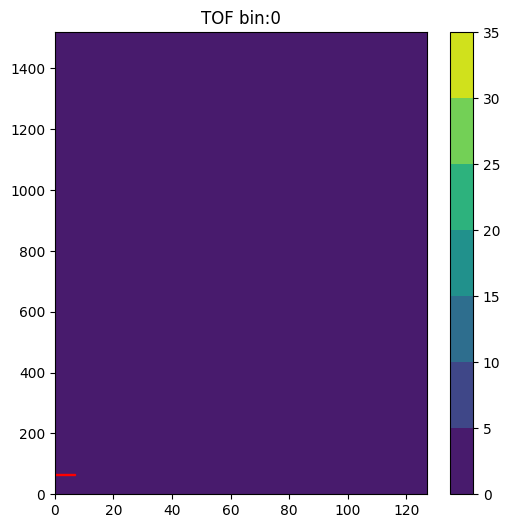

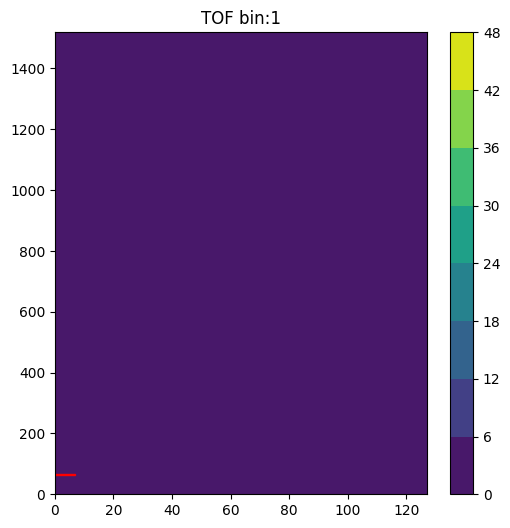

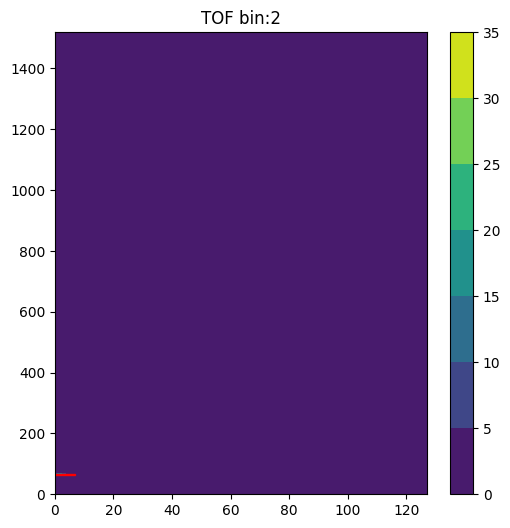

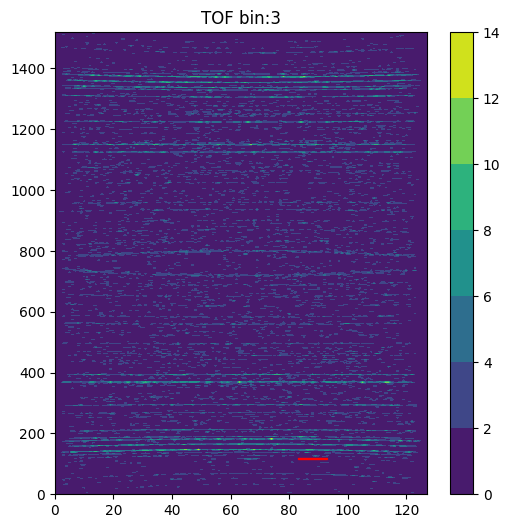

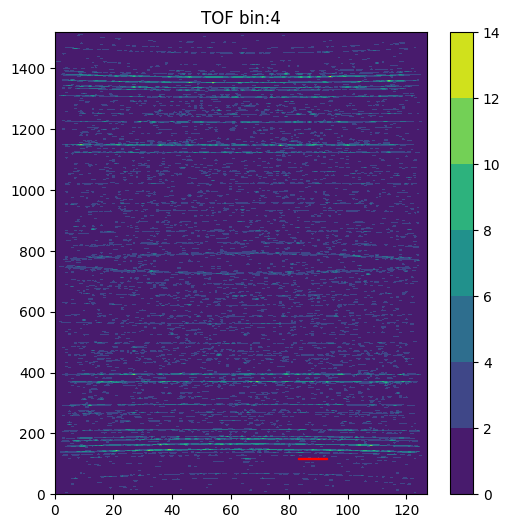

In [27]:
i=0
for (im, tar) in ds:
    plot_bin(im[:,:,0], tar['boxes'], i)
    i+=1
    if i == 5:
        break

### Calculate the stats

In [28]:
# dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
# stats = get_stats(dl)
# stats

In [29]:
# stats = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
# stats

### Training and test data sets

In [30]:
# use our dataset and defined transformations
stats=None
dataset = WishDataSet(annotations_dir, transforms=get_transform(train=True, stats=stats))
dataset_test = WishDataSet(annotations_dir, transforms=get_transform(train=False, stats=stats))

In [31]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

### Model Training fasterrcnn_resnet50_fpn_v2

In [32]:
# to train on gpu if selected.
device = tc.device('cuda:1') if tc.cuda.is_available() else tc.device('cpu')

num_classes = 2

# get the model using our helper function
model = get_object_detection_model_v2(num_classes, pretrained=False)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [33]:
# model = tc.nn.DataParallel(model, device_ids=[0,1])

In [34]:
freeze_to(model, False)

In [35]:
device

device(type='cuda', index=1)

In [36]:
[p.requires_grad for p in model.parameters()]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [37]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [38]:
len(params)

209

In [39]:
lr_scheduler

### Training 

In [40]:
num_epochs = 20
for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [   0/1538]  eta: 0:35:35  lr: 0.000010  loss: 2.7337 (2.7337)  loss_classifier: 0.6458 (0.6458)  loss_box_reg: 0.0097 (0.0097)  loss_objectness: 0.7021 (0.7021)  loss_rpn_box_reg: 1.3762 (1.3762)  time: 1.3885  data: 0.2451  max mem: 0
Epoch: [0]  [  50/1538]  eta: 0:24:43  lr: 0.000260  loss: 1.9409 (2.3853)  loss_classifier: 0.1359 (0.3668)  loss_box_reg: 0.0030 (0.0063)  loss_objectness: 0.6694 (0.6886)  loss_rpn_box_reg: 1.1780 (1.3235)  time: 1.0047  data: 0.0213  max mem: 0
Epoch: [0]  [ 100/1538]  eta: 0:24:13  lr: 0.000509  loss: 1.4066 (1.9860)  loss_classifier: 0.0478 (0.2126)  loss_box_reg: 0.0083 (0.0064)  loss_objectness: 0.5684 (0.6414)  loss_rpn_box_reg: 0.8075 (1.1256)  time: 1.0301  data: 0.0208  max mem: 0
Epoch: [0]  [ 150/1538]  eta: 0:23:33  lr: 0.000759  loss: 1.4034 (1.8077)  loss_classifier: 0.0266 (0.1528)  loss_box_reg: 0.0088 (0.0071)  loss_objectness: 0.5446 (0.6131)  loss_rpn_box_reg: 0.8250 (1.0347)  time: 1.0330  data: 0.0212

#### Save the trained model

In [41]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/fasterrcnn_resnet50_fpn_v2_trained_from_beginning_4x10box.pt'

In [42]:
tc.save(model.state_dict(), model_save_path)

In [43]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with tc.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  2


In [44]:
prediction

{'boxes': tensor([[100.5246, 299.8848, 110.5263, 303.8655],
         [ 31.7490, 303.1011,  41.8015, 307.1493]], device='cuda:1'),
 'labels': tensor([1, 1], device='cuda:1'),
 'scores': tensor([0.9731, 0.9676], device='cuda:1')}

In [45]:
target

{'boxes': tensor([[ 32., 301.,  42., 305.],
         [101., 300., 111., 304.]]),
 'labels': tensor([1, 1]),
 'area': tensor([40., 40.]),
 'iscrowd': tensor([0, 0]),
 'image_id': 1745}

In [46]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[100.5246, 299.8848, 110.5263, 303.8655],
         [ 31.7490, 303.1011,  41.8015, 307.1493]], device='cuda:1'),
 'labels': tensor([1, 1], device='cuda:1'),
 'scores': tensor([0.9731, 0.9676], device='cuda:1')}

In [47]:
img.shape

torch.Size([3, 1520, 128])

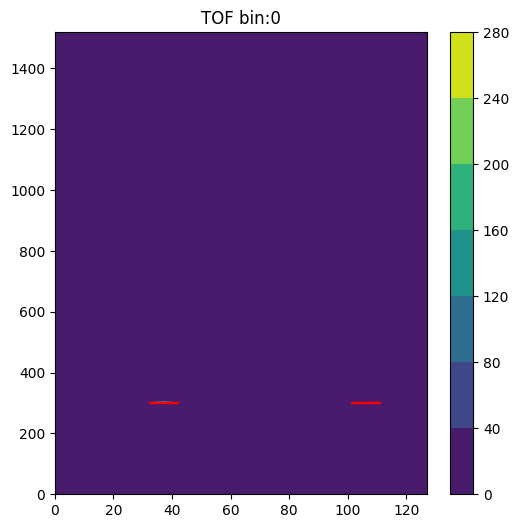

In [48]:
plot_bin(img[0,:,:], target['boxes'], 0)

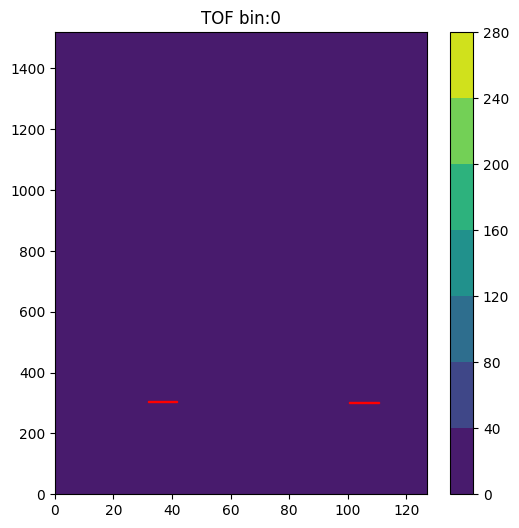

In [49]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

### Load the model from disk

In [52]:
r_model = get_object_detection_model_v2(num_classes)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

In [53]:
img, target = dataset_test[100]
r_model.eval()
with tc.no_grad():
    prediction = r_model([img.to(device)])[0]
prediction

{'boxes': tensor([[  98.9680, 1212.7207,  108.9192, 1216.7284],
         [  19.5552, 1208.1208,   29.5127, 1212.1007],
         [  19.6629, 1206.8010,   29.6778, 1210.8085]], device='cuda:1'),
 'labels': tensor([1, 1, 1], device='cuda:1'),
 'scores': tensor([0.9669, 0.9238, 0.1005], device='cuda:1')}

In [54]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
nms_prediction

{'boxes': tensor([[  98.9680, 1212.7207,  108.9192, 1216.7284],
         [  19.5552, 1208.1208,   29.5127, 1212.1007]], device='cuda:1'),
 'labels': tensor([1, 1], device='cuda:1'),
 'scores': tensor([0.9669, 0.9238], device='cuda:1')}

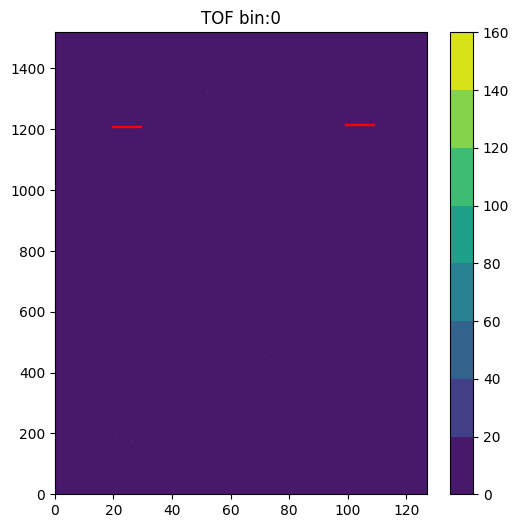

In [55]:
plot_bin(img[0,:,:], nms_prediction['boxes'].cpu(), 0)

{'boxes': tensor([[  22.1759, 1466.7493,   32.1252, 1470.6831],
        [  42.8658,  217.8494,   52.7985,  221.8378],
        [  56.2877,  218.5078,   66.2906,  222.5588],
        [  69.7931,  219.4955,   79.6961,  223.5269],
        [ 117.9558, 1469.1564,  127.4463, 1473.1754],
        [  42.9383,  216.3210,   52.9396,  220.2330]], device='cuda:1'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.9504, 0.9223, 0.9081, 0.5862, 0.4622, 0.1538], device='cuda:1')}
{'boxes': tensor([[  22.1759, 1466.7493,   32.1252, 1470.6831],
        [  42.8658,  217.8494,   52.7985,  221.8378],
        [  56.2877,  218.5078,   66.2906,  222.5588],
        [  69.7931,  219.4955,   79.6961,  223.5269],
        [ 117.9558, 1469.1564,  127.4463, 1473.1754]], device='cuda:1'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.9504, 0.9223, 0.9081, 0.5862, 0.4622], device='cuda:1')}
prediction=tensor([  22.1759, 1466.7493,   32.1252, 1470.6831]) score=0.9504223

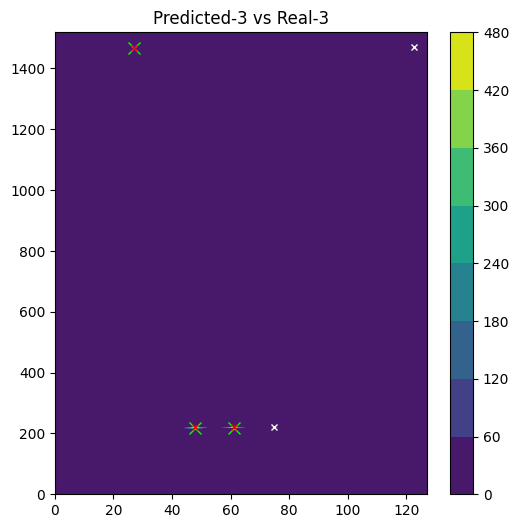

{'boxes': tensor([[ 95.5400,  58.7039, 105.5120,  62.6451],
        [ 33.4946,  60.9404,  43.5847,  65.0700],
        [ 33.7344,  59.5469,  43.7986,  63.5809],
        [ 95.5056,  57.3574, 105.5358,  61.3555]], device='cuda:1'), 'labels': tensor([1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.7173, 0.5390, 0.0763, 0.0515], device='cuda:1')}
{'boxes': tensor([[ 95.5400,  58.7039, 105.5120,  62.6451],
        [ 33.4946,  60.9404,  43.5847,  65.0700]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.7173, 0.5390], device='cuda:1')}
prediction=tensor([ 95.5400,  58.7039, 105.5120,  62.6451]) score=0.7172743082046509
----->Ignoring the prediction at x=100.52598571777344 y=60.67451477050781 with score=0.7172743082046509
prediction=tensor([33.4946, 60.9404, 43.5847, 65.0700]) score=0.5390288829803467
----->Ignoring the prediction at x=38.53963088989258 y=63.00518035888672 with score=0.5390288829803467


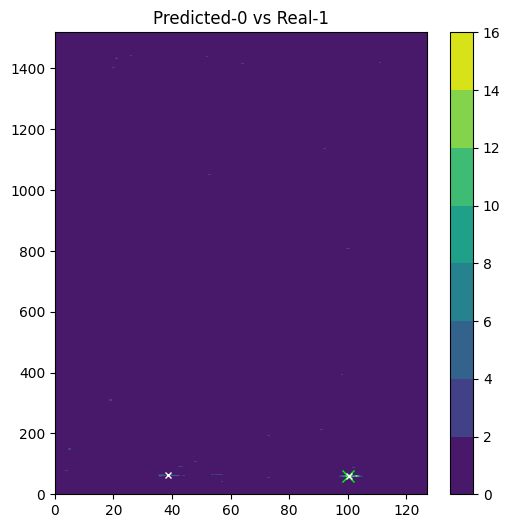

{'boxes': tensor([[3.5362e-01, 7.3154e+02, 9.9223e+00, 7.3552e+02],
        [7.7352e+01, 7.3086e+02, 8.7341e+01, 7.3485e+02],
        [1.0169e+02, 7.2981e+02, 1.1170e+02, 7.3381e+02]], device='cuda:1'), 'labels': tensor([1, 1, 1], device='cuda:1'), 'scores': tensor([0.9846, 0.9494, 0.6996], device='cuda:1')}
{'boxes': tensor([[3.5362e-01, 7.3154e+02, 9.9223e+00, 7.3552e+02],
        [7.7352e+01, 7.3086e+02, 8.7341e+01, 7.3485e+02],
        [1.0169e+02, 7.2981e+02, 1.1170e+02, 7.3381e+02]], device='cuda:1'), 'labels': tensor([1, 1, 1], device='cuda:1'), 'scores': tensor([0.9846, 0.9494, 0.6996], device='cuda:1')}
prediction=tensor([3.5362e-01, 7.3154e+02, 9.9223e+00, 7.3552e+02]) score=0.9846053123474121
Prediction coordinate x=5.137974262237549 y=733.53271484375
prediction=tensor([ 77.3523, 730.8585,  87.3415, 734.8494]) score=0.9494132399559021
Prediction coordinate x=82.34689331054688 y=732.8539428710938
prediction=tensor([101.6858, 729.8062, 111.7045, 733.8124]) score=0.699591755867

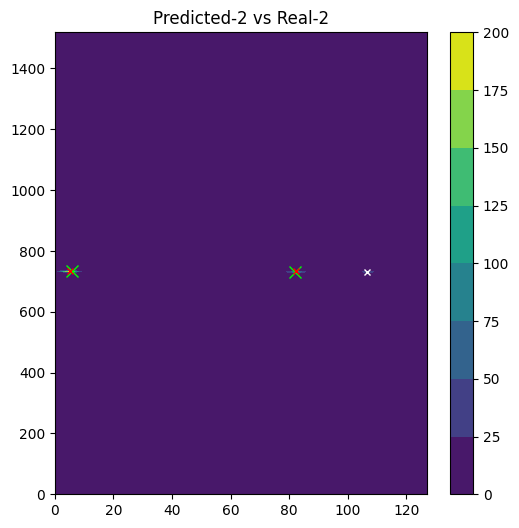

{'boxes': tensor([[ 21.9254, 343.4733,  31.9436, 347.4312],
        [ 97.9755, 338.5474, 107.9678, 342.4715]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9811, 0.9790], device='cuda:1')}
{'boxes': tensor([[ 21.9254, 343.4733,  31.9436, 347.4312],
        [ 97.9755, 338.5474, 107.9678, 342.4715]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9811, 0.9790], device='cuda:1')}
prediction=tensor([ 21.9254, 343.4733,  31.9436, 347.4312]) score=0.9811143279075623
Prediction coordinate x=26.934478759765625 y=345.45220947265625
prediction=tensor([ 97.9755, 338.5474, 107.9678, 342.4715]) score=0.9789501428604126
Prediction coordinate x=102.97164916992188 y=340.50946044921875


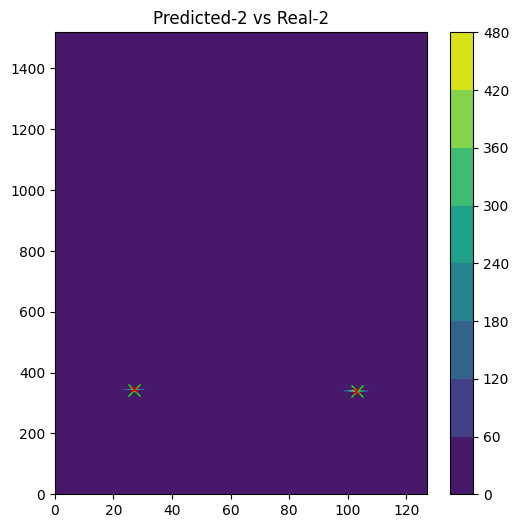

{'boxes': tensor([[8.9974e+01, 2.0923e+02, 9.9976e+01, 2.1325e+02],
        [4.4611e-02, 2.0900e+02, 8.2506e+00, 2.1305e+02],
        [5.1523e+01, 1.1536e+02, 6.1536e+01, 1.1946e+02],
        [3.8828e+01, 1.1550e+02, 4.8905e+01, 1.1953e+02]], device='cuda:1'), 'labels': tensor([1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.9686, 0.8977, 0.8861, 0.7585], device='cuda:1')}
{'boxes': tensor([[8.9974e+01, 2.0923e+02, 9.9976e+01, 2.1325e+02],
        [4.4611e-02, 2.0900e+02, 8.2506e+00, 2.1305e+02],
        [5.1523e+01, 1.1536e+02, 6.1536e+01, 1.1946e+02],
        [3.8828e+01, 1.1550e+02, 4.8905e+01, 1.1953e+02]], device='cuda:1'), 'labels': tensor([1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.9686, 0.8977, 0.8861, 0.7585], device='cuda:1')}
prediction=tensor([ 89.9740, 209.2337,  99.9761, 213.2548]) score=0.9686121940612793
Prediction coordinate x=94.97503662109375 y=211.2442626953125
prediction=tensor([4.4611e-02, 2.0900e+02, 8.2506e+00, 2.1305e+02]) score=0.8976844549179077
Pr

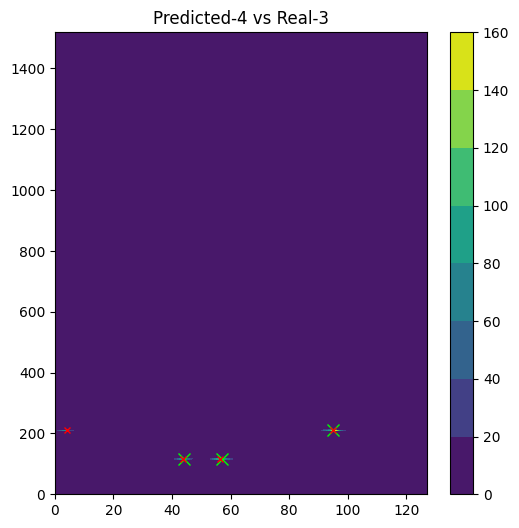

{'boxes': tensor([[100.5246, 299.8848, 110.5263, 303.8655],
        [ 31.7490, 303.1011,  41.8015, 307.1493]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9731, 0.9676], device='cuda:1')}
{'boxes': tensor([[100.5246, 299.8848, 110.5263, 303.8655],
        [ 31.7490, 303.1011,  41.8015, 307.1493]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9731, 0.9676], device='cuda:1')}
prediction=tensor([100.5246, 299.8848, 110.5263, 303.8655]) score=0.9731404781341553
Prediction coordinate x=105.52548217773438 y=301.8751525878906
prediction=tensor([ 31.7490, 303.1011,  41.8015, 307.1493]) score=0.967555582523346
Prediction coordinate x=36.77525329589844 y=305.1252136230469


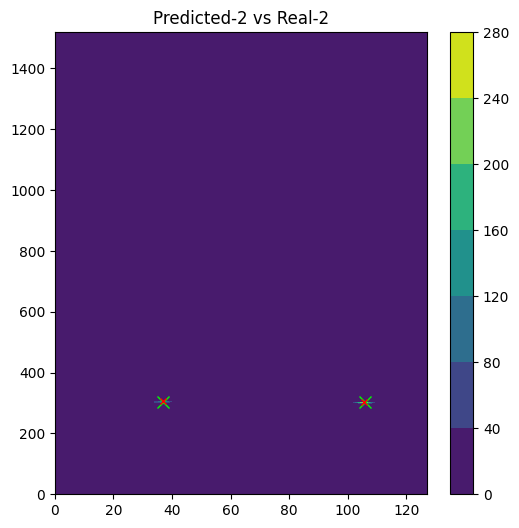

{'boxes': tensor([[ 25.1455, 160.4762,  35.1924, 164.5115],
        [ 82.0342, 157.4190,  92.0849, 161.4369]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9666, 0.9606], device='cuda:1')}
{'boxes': tensor([[ 25.1455, 160.4762,  35.1924, 164.5115],
        [ 82.0342, 157.4190,  92.0849, 161.4369]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9666, 0.9606], device='cuda:1')}
prediction=tensor([ 25.1455, 160.4762,  35.1924, 164.5115]) score=0.9666256904602051
Prediction coordinate x=30.16893768310547 y=162.4938507080078
prediction=tensor([ 82.0342, 157.4190,  92.0849, 161.4369]) score=0.9605681300163269
Prediction coordinate x=87.05952453613281 y=159.42791748046875


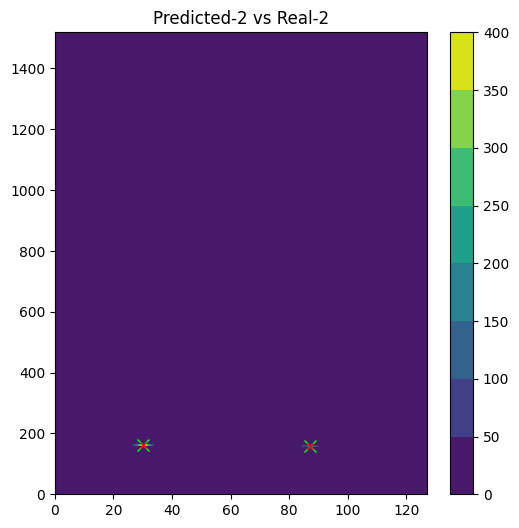

{'boxes': tensor([[ 96.6241, 969.8667, 106.6988, 973.8573],
        [ 29.7523, 971.9858,  39.6338, 975.9968],
        [ 29.8420, 973.4346,  39.5586, 977.3407],
        [ 29.6512, 970.2956,  39.6833, 974.2925]], device='cuda:1'), 'labels': tensor([1, 1, 1, 1], device='cuda:1'), 'scores': tensor([0.9634, 0.8398, 0.1552, 0.1253], device='cuda:1')}
{'boxes': tensor([[ 96.6241, 969.8667, 106.6988, 973.8573],
        [ 29.7523, 971.9858,  39.6338, 975.9968]], device='cuda:1'), 'labels': tensor([1, 1], device='cuda:1'), 'scores': tensor([0.9634, 0.8398], device='cuda:1')}
prediction=tensor([ 96.6241, 969.8667, 106.6988, 973.8573]) score=0.9634316563606262
Prediction coordinate x=101.66146850585938 y=971.8619995117188
prediction=tensor([ 29.7523, 971.9858,  39.6338, 975.9968]) score=0.839806854724884
Prediction coordinate x=34.69305419921875 y=973.9913330078125


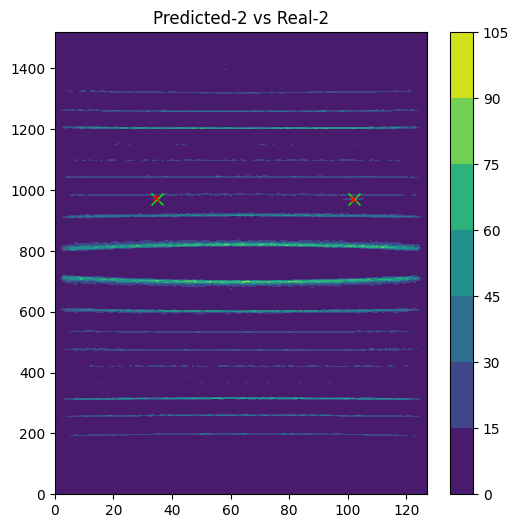

In [56]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            print(prediction)
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            nms_prediction['boxes'] = nms_prediction['boxes'].cpu()
            plot_bin_detections(img[0,:,:], target['boxes'], nms_prediction)
            probe += 1

    if probe >= 1:
        break